# Laboratory work #2

Import all significant libraries for this project.

In [1]:
# Import scikit-learn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

# Import keras function for loading image
from keras.utils.image_utils import load_img

# Import other libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time

#### Downloading Dataset
Our dataset is Possible Asteroid Impacts with Earth (from [kaggle](https://www.kaggle.com/datasets/nasa/asteroid-impacts))

# Exercise #1

## Preprocessing Dataset

In [21]:
# Loading dataset to pandas DataFrame
asteroid_df = pd.read_csv("datasets\\asteroid_dataset\\asteroid_classification.csv")

In [22]:
# Drop unnecessary columns for analysis from the dataframe
asteroid_df.drop(["Object Name", "Epoch (TDB)", "Perihelion Argument (deg)", "Node Longitude (deg)",
                  "Mean Anomoly (deg)", "Perihelion Distance (AU)", "Aphelion Distance (AU)",
                  "Minimum Orbit Intersection Distance (AU)", "Orbital Reference"], axis=1, inplace=True)
print(asteroid_df.columns)

Index(['Object Classification', 'Orbit Axis (AU)', 'Orbit Eccentricity',
       'Orbit Inclination (deg)', 'Orbital Period (yr)', 'Asteroid Magnitude'],
      dtype='object')


In [23]:
# Drop null values of dataframe as we have only one null value
asteroid_df.dropna(inplace=True)
asteroid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15634 entries, 0 to 15634
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Object Classification    15634 non-null  object 
 1   Orbit Axis (AU)          15634 non-null  float64
 2   Orbit Eccentricity       15634 non-null  float64
 3   Orbit Inclination (deg)  15634 non-null  float64
 4   Orbital Period (yr)      15634 non-null  float64
 5   Asteroid Magnitude       15634 non-null  float64
dtypes: float64(5), object(1)
memory usage: 855.0+ KB


In [15]:
# Drop the 90% of data in dataframe
asteroid_df_size = asteroid_df.size
asteroid_df = asteroid_df[:int(asteroid_df_size*0.5)]

In [24]:
# Change class names
asteroid_df["Object Classification"].mask(asteroid_df["Object Classification"] == "Apollo Asteroid" ,
                                          "Apollo", inplace=True)
asteroid_df["Object Classification"].mask(asteroid_df["Object Classification"] == "Aten Asteroid",
                                          "Aten", inplace=True)
asteroid_df["Object Classification"].mask(asteroid_df["Object Classification"] == "Amor Asteroid",
                                          "Amor", inplace=True)
asteroid_df["Object Classification"].mask(asteroid_df["Object Classification"] == "Apohele Asteroid",
                                          "Apohele", inplace=True)
# Drop unnecessary class
necessary_class = ["Apollo", "Aten", "Amor"]
asteroid_df = asteroid_df[asteroid_df["Object Classification"].isin(necessary_class)]

In [25]:
def remove_outliers(dataframe, features):
    """Function to remove the outliers;
    :param dataframe: pandas DataFrame with data;
    :param features: list with features from dataframe.
    """
    # Copy dataframe to another variable
    dataframe_copy = dataframe.copy()

    # Iterate through features
    for feature in features:
        if dataframe[feature].dtype == object:
            continue
        # Calculate q1, q3 and iqr
        q3 = dataframe[feature].quantile(0.75)
        q1 = dataframe[feature].quantile(0.25)
        iqr = q3 - q1

        # Get local minimum and maximum
        local_min = q1 - (1.5 * iqr)
        local_max = q3 + (1.5 * iqr)

        # Remove the outliers
        dataframe_copy = dataframe_copy[(dataframe_copy[feature] >= local_min) &
                                        (dataframe_copy[feature] <= local_max)]

    return dataframe_copy

In [26]:
# Extract features from the df
asteroid_features = asteroid_df.columns.tolist()
print(asteroid_features)

['Object Classification', 'Orbit Axis (AU)', 'Orbit Eccentricity', 'Orbit Inclination (deg)', 'Orbital Period (yr)', 'Asteroid Magnitude']


In [27]:
# Remove outliers from the dataframe
asteroid_df = remove_outliers(asteroid_df, asteroid_features)

In [28]:
# View count of class names
print(asteroid_df.iloc[:, 0].value_counts())

Apollo    6651
Amor      5686
Aten       965
Name: Object Classification, dtype: int64


In [29]:
# View dataset columns
asteroid_df.keys()

Index(['Object Classification', 'Orbit Axis (AU)', 'Orbit Eccentricity',
       'Orbit Inclination (deg)', 'Orbital Period (yr)', 'Asteroid Magnitude'],
      dtype='object')

In [30]:
# Normalise dataset
norm_asteroid_df = asteroid_df.copy()
# apply normalization techniques
for column in norm_asteroid_df:
    if norm_asteroid_df[column].dtype == object:
        continue
    norm_asteroid_df[column] = norm_asteroid_df[column] / norm_asteroid_df[column].abs().max()
# View normalised dataset
print(norm_asteroid_df.head())

  Object Classification  Orbit Axis (AU)  Orbit Eccentricity  \
1                  Amor         0.807646            0.590282   
2                  Amor         0.758732            0.610967   
4                  Amor         0.587438            0.469295   
8                  Amor         0.570204            0.427279   
9                Apollo         0.418531            0.469619   

   Orbit Inclination (deg)  Orbital Period (yr)  Asteroid Magnitude  
1                 0.296677             0.727119            0.492063  
2                 0.239656             0.661017            0.425397  
4                 0.304293             0.450847            0.561905  
8                 0.216477             0.430508            0.419048  
9                 0.240286             0.271186            0.451746  


In [31]:
# Edit name of column "Object Classification" with _
# For using this name in next cell
number_asteroid_df = norm_asteroid_df.copy()
number_asteroid_df.rename(columns={"Object Classification": "Object_Classification"}, inplace=True)
# Replace string class to numbers
obj_class = {"Apollo": 0, "Aten": 1, "Amor": 2}
number_asteroid_df.Object_Classification = [obj_class[item] for item in number_asteroid_df.Object_Classification]
# View new dataset
print(number_asteroid_df.head())

   Object_Classification  Orbit Axis (AU)  Orbit Eccentricity  \
1                      2         0.807646            0.590282   
2                      2         0.758732            0.610967   
4                      2         0.587438            0.469295   
8                      2         0.570204            0.427279   
9                      0         0.418531            0.469619   

   Orbit Inclination (deg)  Orbital Period (yr)  Asteroid Magnitude  
1                 0.296677             0.727119            0.492063  
2                 0.239656             0.661017            0.425397  
4                 0.304293             0.450847            0.561905  
8                 0.216477             0.430508            0.419048  
9                 0.240286             0.271186            0.451746  


In [50]:
# Set X variable
X = number_asteroid_df.drop(["Object_Classification"], axis=1)
y = number_asteroid_df["Object_Classification"]

## Use PCA (Principal Component Analysis)

In [51]:
# Set scaler and train on X var
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [52]:
# Set PCA class object and train on X_std var
pca = PCA()
X_pca = pca.fit_transform(X_std)

In [53]:
# Set explained variance ration and cumulative sum for PCA
exp_var_pca =  pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

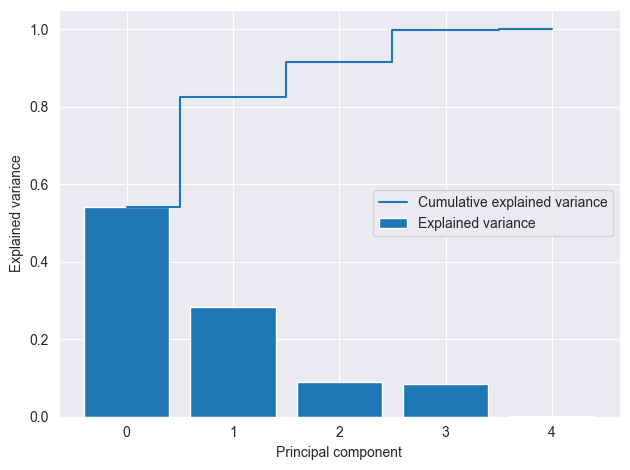

In [54]:
# View explained variance ration and cumulative sum on plot
plt.bar(range(0, len(exp_var_pca)), exp_var_pca, align='center', label="Explained variance")
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid', label="Cumulative explained variance")
plt.ylabel("Explained variance")
plt.xlabel("Principal component")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [55]:
# Set PCA class object with n_components=2 (this will reduce the dimension to two)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

pca_result_df = pd.DataFrame({'pca_1': pca_result[:, 0], 'pca_2': pca_result[:, 1], 'label': y})

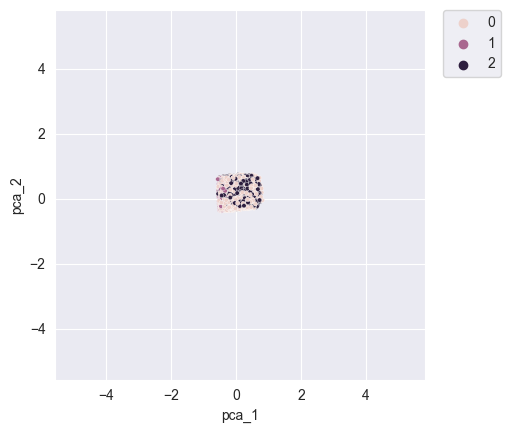

In [56]:
# View result on plot
fig, ax = plt.subplots(1)
sns.scatterplot(x='pca_1', y='pca_2', hue='label', data=pca_result_df, ax=ax, s=10)
limit = (pca_result.min()-5, pca_result.max()+5)
ax.set_xlim(limit)
ax.set_ylim(limit)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

## Use TSNE (T-distributed Stochastic Neighbor Embedding)

In [57]:
# Set TSNE class object with n_components=2 (this will reduce the dimension to two)
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(X)

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:, 0], 'tsne_2': tsne_result[:, 1], 'label': y})

D:\.main\.code\data_analysis_labs\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\.main\.code\data_analysis_labs\venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


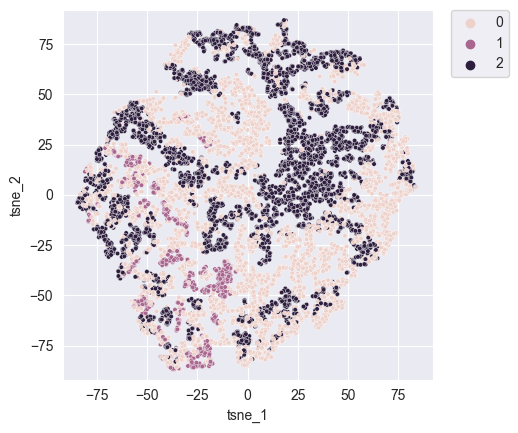

In [58]:
# View result on plot
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax, s=10)
limit = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(limit)
ax.set_ylim(limit)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

# Exercise #2
Cluster analysis (image quantisation)

## Prepare function for analysis

In [13]:
def image_quantisation(image_array, rand_state, color_depth=64, n_samples=1000):
    """

    :param image_array:
    :param rand_state:
    :param n_samples:
    :param color_depth:
    :return:
    """
    # Fitting model on small sub-sample with KMeans
    print("Fitting model on a small sub-sample of the data")
    t0 = time()
    image_array_sample = shuffle(image_array, random_state=rand_state, n_samples=n_samples)
    kmeans = KMeans(n_clusters=color_depth, random_state=rand_state).fit(image_array_sample)
    print(f"Done in {time() - t0:0.3f}s.")

    # Get labels for all points
    print("Predicting color indices on the full image (k-means)")
    t0 = time()
    labels = kmeans.predict(image_array)
    print(f"Done in {time() - t0:0.3f}s.")

    return kmeans, labels


def recreate_image(codebook, labels, width, height):
    """

    :param codebook:
    :param labels:
    :param width:
    :param height:
    :return:
    """
    return codebook[labels].reshape(width, height, -1)


def visualise_quantisation(model, labels, color_depth, width, height):
    """

    :param model:
    :param labels:
    :param width:
    :param height:
    :return:
    """
    plt.figure()
    plt.clf()
    plt.axis("off")
    plt.title(f"Quantised image ({color_depth} colors, K-Means)")
    plt.imshow(recreate_image(model.cluster_centers_, labels, width, height))

## Preprocessing Dataset

In [30]:
# Set random state
rand_state = 17
# Load the photo
image_path = "datasets\\amazon_books_reviews\\skyscraper.png"
skyscraper = load_img(image_path)

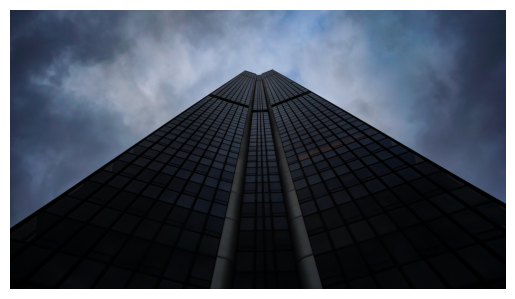

In [33]:
# View image
plt.imshow(skyscraper)
plt.axis("off")
plt.show()

In [34]:
# Convert data type of image to float64 and normalize image with dividing by 255
skyscraper = np.array(skyscraper, dtype=np.float64) / 255

In [35]:
# Load image and transform to a 2D numpy array
width, height, color = original_shape = tuple(skyscraper.shape)
assert color == 3
image_array = np.reshape(skyscraper, (width*height, color))

## Fitting model

In [44]:
## Fitting model with 64 colour depth
# Set colour depth
color_depth_64 = 64
# Quantise image
model_64, labels_64 = image_quantisation(image_array, rand_state, color_depth_64)

Fitting model on a small sub-sample of the data
Done in 1.000s.
Predicting color indices on the full image (k-means)
Done in 1.166s.


In [45]:
## Fitting model with 64 colour depth
# Set colour depth
color_depth_32 = 32
# Quantise image
model_32, labels_32 = image_quantisation(image_array, rand_state, color_depth_32)

Fitting model on a small sub-sample of the data
Done in 0.597s.
Predicting color indices on the full image (k-means)
Done in 0.620s.


In [46]:
## Fitting model with 64 colour depth
# Set colour depth
color_depth_16 = 16
# Quantise image
model_16, labels_16 = image_quantisation(image_array, rand_state, color_depth_16)

Fitting model on a small sub-sample of the data
Done in 0.489s.
Predicting color indices on the full image (k-means)
Done in 0.424s.


In [47]:
## Fitting model with 64 colour depth
# Set colour depth
color_depth_8 = 8
# Quantise image
model_8, labels_8 = image_quantisation(image_array, rand_state, color_depth_8)

Fitting model on a small sub-sample of the data
Done in 0.478s.
Predicting color indices on the full image (k-means)
Done in 0.333s.


## Visualise result

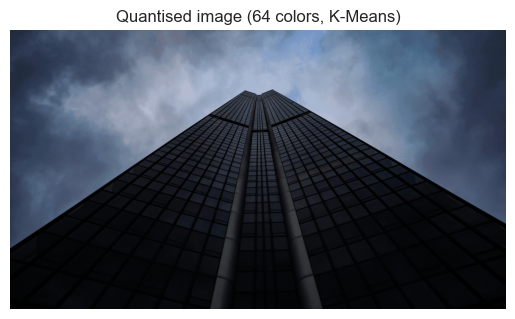

In [48]:
## Visualise for 64 colour depth
visualise_quantisation(model_64, labels_64, color_depth_64, width, height)

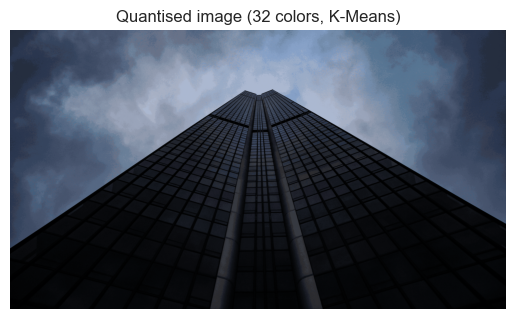

In [49]:
## Visualise for 32 colour depth
visualise_quantisation(model_32, labels_32, color_depth_32, width, height)

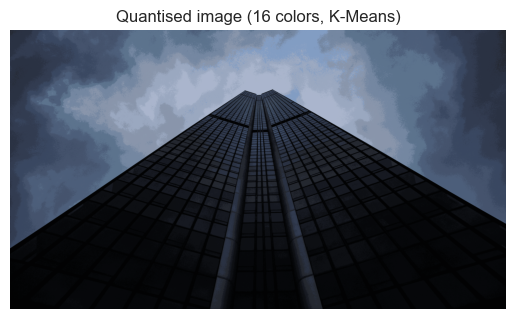

In [50]:
## Visualise for 16 colour depth
visualise_quantisation(model_16, labels_16, color_depth_16, width, height)

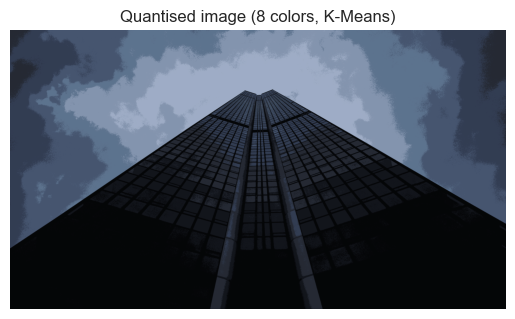

In [51]:
## Visualise for 8 colour depth
visualise_quantisation(model_8, labels_8, color_depth_8, width, height)

# Exercise #3

## Preprocessing Dataset

In [63]:
# Load dataset
tweet_emotions = pd.read_csv("datasets\\emotion_detection_text\\tweet_emotions.csv")

In [64]:
# Drop NA values
tweet_emotions.dropna(inplace=True)
tweet_emotions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [65]:
# View dataset
tweet_emotions.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [66]:
# View dataset columns
tweet_emotions.keys()

Index(['tweet_id', 'sentiment', 'content'], dtype='object')

In [68]:
# Drop unnecessary columns
tweet_emotions.drop(["tweet_id"], axis=1, inplace=True)

In [72]:
# View columns again
tweet_emotions.columns

Index(['sentiment', 'content'], dtype='object')

## Make classification of text data
### (make assessment of quality)

## Visualise result